In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import activations, datasets, layers, models, regularizers
from IPython.display import clear_output
import datetime
from tensorflow.keras.layers import Layer
from tensorflow.keras import Model
from sklearn.manifold import TSNE
import time

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
# This time we don't need to zip the labels and the images back together as we don't need those labels during training or validation
train_dataset_images = tf.data.Dataset.from_tensor_slices(train_images)

test_dataset_images = tf.data.Dataset.from_tensor_slices(test_images)

train_dataset_images = train_dataset_images.map(lambda img: img/255)
train_dataset_images = train_dataset_images.map(lambda img: tf.reshape(img, (28,28,1)))
test_dataset_images = test_dataset_images.map(lambda img: img/255)
test_dataset_images = test_dataset_images.map(lambda img: tf.reshape(img, (28,28,1)))

train_dataset = train_dataset_images.batch(64)
train_dataset.shuffle(64)

test_dataset = test_dataset_images.batch(64)
test_dataset.shuffle(64)

<ShuffleDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [ ]:
# The encoder class basicly stacks two convolutional layer to size down the image
class Encoder(tf.keras.layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.conv_01 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (2,2), strides = 2, activation = None, input_shape = (28,28,1 ))
        self.batch_norm_01 = tf.keras.layers.BatchNormalization()
        self.activation_01 = tf.keras.activations.relu

        self.conv_02 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (2,2), activation = None, strides = 2)
        self.batch_norm_02 = tf.keras.layers.BatchNormalization()
        self.activation_02 = tf.keras.activations.relu

        self.flatten = tf.keras.layers.Flatten()
        
        self.embedding = tf.keras.layers.Dense(units = 10, activation = 'relu')
        
    def call(self, x, training_flag):
        x = self.conv_01(x)
        x = self.batch_norm_01(x, training = training_flag)
        x = self.activation_01(x)
        x = self.conv_02(x)
        x = self.batch_norm_02(x, training = training_flag)
        x = self.activation_02(x)
        x = self.flatten(x)
        x = self.embedding(x)
        return x

In [ ]:
# The decoder class does the opposite of the encoder class. By using Conv2DTranspose-Layers, the image is scaled back up again
class Decoder(tf.keras.layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.dense = tf.keras.layers.Dense(units = 1568, activation = 'relu', input_shape = (64,10))
        
        self.reshape = tf.keras.layers.Reshape(target_shape=(7, 7, 32))
        
        self.transp_conv_01 = tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = (3,3), strides = 2, padding = 'same', activation = None)
        self.batch_norm_01 = tf.keras.layers.BatchNormalization()
        self.activation_01 = tf.keras.activations.relu

        self.transp_conv_02 = tf.keras.layers.Conv2DTranspose(filters = 32, kernel_size = (3,3), strides = 2, padding = 'same', activation = None)
        self.batch_norm_02 = tf.keras.layers.BatchNormalization()
        self.activation_02 = tf.keras.activations.relu
        self.output_layer = tf.keras.layers.Conv2D(filters = 1, kernel_size = (1,1), activation = 'sigmoid')
    
    def call(self, x, training_flag):
        x = self.dense(x)
        x = self.reshape(x)
        x = self.transp_conv_01(x)
        x = self.batch_norm_01(x, training = training_flag)
        x = self.activation_01(x)
        x = self.transp_conv_02(x)
        x = self.batch_norm_02(x, training = training_flag)
        x = self.activation_02(x)
        x = self.output_layer(x)
        return x

In [ ]:
# The autoencoder class combines both the encoder and the decoder class and runs them both in sequenze in the call function
class Autoencoder(tf.keras.layers.Layer):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def call(self, x, training):
        x = self.encoder(x, training)
        x = self.decoder(x, training)
        return x
    
    def encode(self, x, training):
        x = self.encoder(x, training)
        return x
    
    def decode(self, x, training):
        x = self.decoder(x, training)
        return x

In [ ]:
def train_step(model, input, loss_function, optimizer, training = True):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    #n_samples = input.shape[0]
    prediction = model(input, training)
    loss = loss_function(input, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function, training = False):
  # test over complete test data

  test_loss_aggregator = []
  input_images = []
  reconstructed_images = []

  for i, input in enumerate(test_data):
    prediction = model(input, training)
    sample_test_loss = loss_function(input, prediction)
    test_loss_aggregator.append(sample_test_loss.numpy())
    if (i < 10):
      input_images.append(input.numpy()[0])
      reconstructed_images.append(prediction.numpy()[0])
  test_loss = np.mean(test_loss_aggregator)

  return test_loss, input_images, reconstructed_images

In [ ]:
def calculateTime(epochs, time_passed, number_of_epochs):
    epochs = epochs + 1
    time_per_epoch = time_passed / epochs
    number = number_of_epochs - epochs
    time_sec = number * time_per_epoch
    time_remain = str(datetime.timedelta(seconds=time_sec))
    return time_remain

In [ ]:
# Visualize loss for training and test data. 
# Plot training and test loss.
def visualize():
  plt.figure()
  line1, = plt.plot(train_losses)
  line2, = plt.plot(test_losses)
  plt.xlabel("Training steps")
  plt.ylabel("Loss")
  plt.legend((line1,line2),("training","test"))
  plt.show()
  print("Current train loss: ", train_losses[-1])
  if len(train_losses) >= 2:
    print("Change of train loss to previous epoch: ", train_losses[-1] - train_losses[-2])
  print("Current test loss: ", test_losses[-1])
  if len(test_losses) >= 2:
    print("Change of test loss to previous epoch: ", test_losses[-1] - test_losses[-2])

In [ ]:
# We use the function visualize_images to show the original images and the reconstructed images after encoding and decoding them so we can observe the performance of our autoencoder in a better way.
def visualize_images(input_images, reconstructed_images):
  fig, ax = plt.subplots(2,10)
  for i in range(10):
    ax[0][i].imshow(input_images[i].reshape(28,28), cmap='gray')
    ax[0][i].get_xaxis().set_visible(False)
    ax[0][i].get_yaxis().set_visible(False)
    ax[1][i].imshow(tf.reshape(reconstructed_images[i],(28,28)), cmap='gray')
    ax[1][i].get_xaxis().set_visible(False)
    ax[1][i].get_yaxis().set_visible(False)
  plt.show()

Time until training is finished:  0:00:00
Visualization of Training/Test loss:


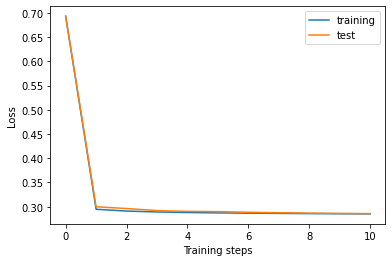

Current train loss:  tf.Tensor(0.28516343, shape=(), dtype=float32)
Change of train loss to previous epoch:  tf.Tensor(-0.00029474497, shape=(), dtype=float32)
Current test loss:  0.28573483
Change of test loss to previous epoch:  -0.00059747696


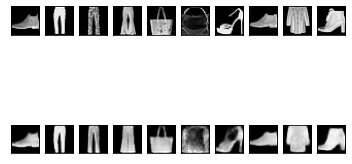

In [ ]:
# During training this time you don't have to use any labels. Instead you at train_step you only hand over the input image as this is also the target value

tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.001
running_average_factor = 0.95

# Initialize the model.
model = Autoencoder()

# Initialize the loss: binary cross entropy
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer: Adam with default parameters, using set learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []

#testing once before we begin

test_loss, _, _ = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
#check how model performs on train data once before we begin
train_loss, _, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

start = time.time()

print("Makes it into training loop")
# We train for num_epochs epochs.
for epoch in range(num_epochs):
    epoch_start = time.time()
    print('Epoch: __ ' + str(epoch))

    #training (and checking in with training)
    running_average = 0
    for input in train_dataset:
        train_loss = train_step(model, input, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, input_images, reconstructed_images = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    clear_output(wait = True)
    print("Time until training is finished: ", calculateTime(epoch, time.time()-start, num_epochs))
    print("Visualization of Training/Test loss:")
    visualize()
    visualize_images(input_images, reconstructed_images)

In [ ]:
embeddings = []
labels = train_labels[:1000]
for i in range(1000):
  variable = train_images[i].reshape(1,28,28,1)
  variable = np.array(variable, dtype=float)
  variable = model.encode(variable, False)[0].numpy()
  embeddings.append(variable)
embeddings = TSNE(n_components = 2).fit_transform(embeddings)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



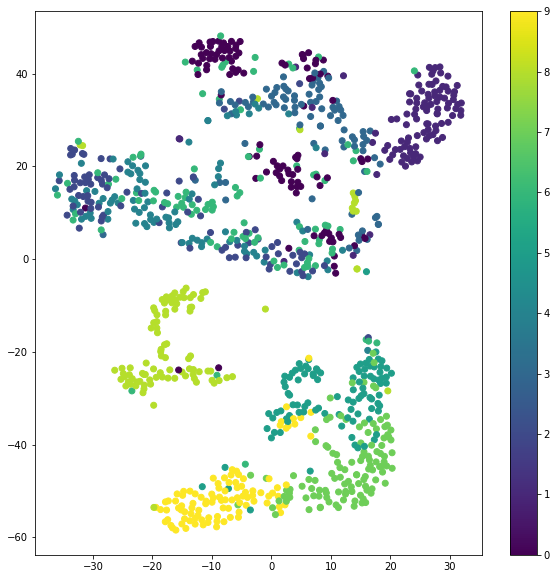

In [ ]:
# This scatter graph shows how the different types of clothing are grouped together by the autoencoder.
# It is pretty much what we expected in that points of different labels are generally grouped together.
# This makes sense in regard to the courseware content, as the embedding is supposed to represent the original information in a concise way.

plt.figure(figsize=(10,10))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=labels)
plt.colorbar()
plt.show()

In [ ]:
def interpolation(img1,img2, img1_decoded, img2_decoded, interpolation):
  fig, ax = plt.subplots(2, 3)
  ax[0][0].set_title("Image 1")
  ax[0][0].imshow(img1.reshape(28,28), cmap='gray')
  ax[0][0].set_axis_off()
  ax[0][1].set_title("Image 2")
  ax[0][1].imshow(img2.reshape(28,28), cmap='gray')
  ax[0][1].set_axis_off()
  ax[0][2].set_axis_off()
  ax[1][0].set_title("Image 1 decoded")
  ax[1][0].imshow(tf.reshape(img1_decoded,(28,28)), cmap='gray')
  ax[1][0].set_axis_off()
  ax[1][1].set_title("Image 2 decoded")
  ax[1][1].imshow(tf.reshape(img2_decoded,(28,28)),cmap='gray')
  ax[1][1].set_axis_off()
  ax[1][2].set_title("Interpolation")
  ax[1][2].set_axis_off()
  ax[1][2].imshow(tf.reshape(interpolation,(28,28)), cmap = 'gray')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



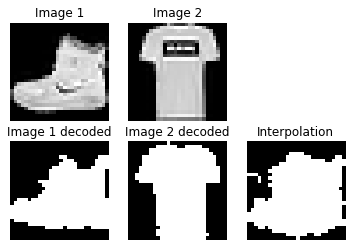

In [ ]:
# We weren't really sure what to make of this part of the task as we don't know what was ment with interpolation and unfortunately we handled this too late to ask.
# We decided to take the mean of the embeddings and treat this as the interpolation. To make up for the somewhat incomplete solution to this task, we also implemented a VAE, although not good enough for an outstanding.
img1 = np.array(train_images[0].reshape(1,28,28,1), dtype = float)
img2 = np.array(train_images[1].reshape(1,28,28,1), dtype = float)
img1_decoded = model(img1, False)
img2_decoded = model(img2, False)
interpolated_embedding = (model.encode(img1, False) + model.encode(img2, False) / 2)
reconstructed_interpolated_img = model.decode(interpolated_embedding, False)
interpolation(img1, img2, img1_decoded, img2_decoded, reconstructed_interpolated_img)

In [ ]:
# Our VAE encoder stacks two Conv2D-Layers and one Dense-Layer. After that we use a MultivariateNormalTriL-Layer to only output 10 parameters which can be used to reconstruct the image
# The decoder then takes those 10 parameters and reconstructs the image from those parameters

class VAE(tf.keras.layers.Layer):
  def __init__(self):
    super(VAE, self).__init__()

    # we set the prior which represents how we want the elements of our embedding to be distributed, in this case we use the standard normal distribution N(0,1)
    # because our embedding has 10 elements, we instantiate 10 independent standard normal distribution, we also set the dimensions to 1 as our embedding is a vector
    self.prior = tfp.distributions.Independent(distribution = tfp.distributions.Normal(loc = tf.zeros(10), scale = 1), reinterpreted_batch_ndims = 1)

    self.encoder = [
                    tf.keras.layers.Conv2D(filters = 32, kernel_size = (2,2), strides = 2, activation = 'relu', input_shape = (28,28,1 )),
                    tf.keras.layers.Conv2D(filters = 32, kernel_size = (2,2), activation = 'relu', strides = 2),
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(units = 65, activation=None),
                    tfp.layers.MultivariateNormalTriL(event_size=10, activity_regularizer = tfp.layers.KLDivergenceRegularizer(distribution_b=self.prior, weight = 1))


    ]

    self.decoder = [
                    tf.keras.layers.Dense(units = 1568, activation = 'relu', input_shape = (64,10)),
                    tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                    tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = (3,3), strides = 2, padding = 'same', activation = 'relu'),
                    tf.keras.layers.Conv2DTranspose(filters = 32, kernel_size = (3,3), strides = 2, padding = 'same', activation = 'relu'),
                    tf.keras.layers.Conv2D(filters = 1, kernel_size = (1,1), activation = None),
                    tf.keras.layers.Flatten(),
                    tfp.layers.IndependentBernoulli(event_shape = (28,28,1), convert_to_tensor_fn = tfp.distributions.Bernoulli.logits)
    ]
  def call(self, x):
    for layer in self.encoder:
      x = layer(x)
    for layer in self.decoder:
      x = layer(x)
    
    return x

In [ ]:
def vae_train_step(model, input, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(input, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  loss = np.mean(loss) + tf.reduce_sum(model.losses)
  return loss

def vae_test(model, test_data, loss_function):
  # test over complete test data

  test_loss_aggregator = []
  input_images = []
  reconstructed_images = []

  for i, input in enumerate(test_data):
    start = time.time()
    prediction = model(input)
    end = time.time()
    sample_test_loss = loss_function(input, prediction) + tf.reduce_sum(model.losses)
    test_loss_aggregator.append(np.mean(sample_test_loss.numpy()))
    if (i < 10):
      input_images.append(input.numpy()[0])
      reconstructed_images.append(prediction[0])

  test_loss = np.mean(test_loss_aggregator)

  return test_loss, input_images, reconstructed_images

Time until training is finished:  0:00:00
Visualization of Training/Test loss:


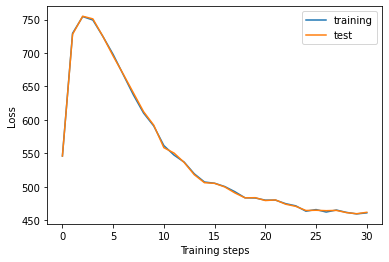

Current train loss:  tf.Tensor(460.93927, shape=(), dtype=float32)
Change of train loss to previous epoch:  tf.Tensor(1.5697021, shape=(), dtype=float32)
Current test loss:  461.78305
Change of test loss to previous epoch:  2.1334534


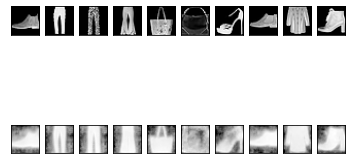

In [ ]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 30
learning_rate = 0.001
running_average_factor = 0.95

# Initialize the model.
model = VAE()

# Initialize the loss: binary cross entropy
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
# Initialize the optimizer: Adam with default parameters, using set learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []

#testing once before we begin

test_loss, _, _ = vae_test(model, test_dataset, negative_log_likelihood)
test_losses.append(test_loss)
#check how model performs on train data once before we begin
train_loss, _, _ = vae_test(model, train_dataset, negative_log_likelihood)
train_losses.append(train_loss)

start = time.time()

print("Makes it into training loop")
# We train for num_epochs epochs.
for epoch in range(num_epochs):
    epoch_start = time.time()
    print('Epoch: __ ' + str(epoch))

    #training (and checking in with training)
    running_average = 0
    for input in train_dataset:
        train_loss = vae_train_step(model, input, negative_log_likelihood, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, input_images, reconstructed_images = vae_test(model, test_dataset, negative_log_likelihood)
    test_losses.append(test_loss)
    clear_output(wait = True)
    print("Time until training is finished: ", calculateTime(epoch, time.time()-start, num_epochs))
    print("Visualization of Training/Test loss:")
    visualize()
    visualize_images(input_images, reconstructed_images)